<a href="https://colab.research.google.com/github/NSR9/ERAv4-session-5/blob/main/ERAv4_session4_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


In [5]:
# Slightly larger batch helps convergence speed in 1 epoch
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

In [6]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

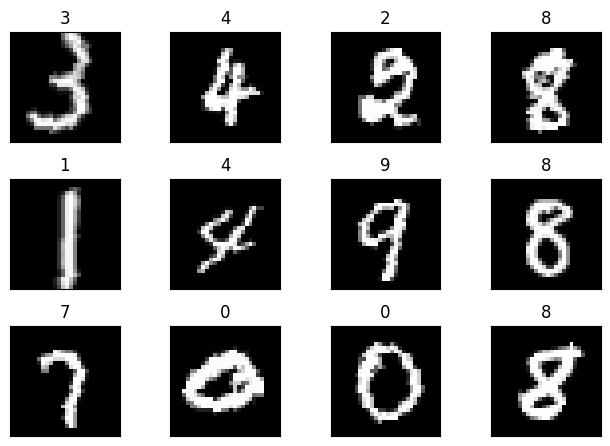

In [7]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        )




        self.fc = nn.Linear(400, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,168
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]           2,320
             ReLU-10           [-1, 16, 28, 28]               0
      BatchNorm2d-11           [-1, 16, 28, 28]              32
        MaxPool2d-12           [-1, 16, 14, 14]               0
          Dropout-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 16,

In [10]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [11]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item() * len(data)  # sum up batch loss multiplied by batch size

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.1920 Batch_id=117 Accuracy=82.51: 100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


Test set: Average loss: 0.1198, Accuracy: 9621/10000 (96.21%)

Epoch 2


Train: Loss=0.0946 Batch_id=117 Accuracy=95.96: 100%|██████████| 118/118 [00:18<00:00,  6.26it/s]


Test set: Average loss: 0.0465, Accuracy: 9853/10000 (98.53%)

Epoch 3


Train: Loss=0.0313 Batch_id=117 Accuracy=97.06: 100%|██████████| 118/118 [00:17<00:00,  6.71it/s]


Test set: Average loss: 0.0366, Accuracy: 9885/10000 (98.85%)

Epoch 4


Train: Loss=0.0828 Batch_id=117 Accuracy=97.57: 100%|██████████| 118/118 [00:19<00:00,  6.07it/s]


Test set: Average loss: 0.0357, Accuracy: 9887/10000 (98.87%)

Epoch 5


Train: Loss=0.0775 Batch_id=117 Accuracy=97.77: 100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Test set: Average loss: 0.0331, Accuracy: 9900/10000 (99.00%)

Epoch 6


Train: Loss=0.0797 Batch_id=117 Accuracy=97.97: 100%|██████████| 118/118 [00:17<00:00,  6.64it/s]


Test set: Average loss: 0.0258, Accuracy: 9919/10000 (99.19%)

Epoch 7


Train: Loss=0.0229 Batch_id=117 Accuracy=98.23: 100%|██████████| 118/118 [00:19<00:00,  6.17it/s]


Test set: Average loss: 0.0331, Accuracy: 9899/10000 (98.99%)

Epoch 8


Train: Loss=0.0423 Batch_id=117 Accuracy=98.32: 100%|██████████| 118/118 [00:18<00:00,  6.27it/s]


Test set: Average loss: 0.0231, Accuracy: 9926/10000 (99.26%)

Epoch 9


Train: Loss=0.0883 Batch_id=117 Accuracy=98.38: 100%|██████████| 118/118 [00:17<00:00,  6.63it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

Epoch 10


Train: Loss=0.0084 Batch_id=117 Accuracy=98.44: 100%|██████████| 118/118 [00:18<00:00,  6.25it/s]


Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

Epoch 11


Train: Loss=0.0320 Batch_id=117 Accuracy=98.44: 100%|██████████| 118/118 [00:17<00:00,  6.61it/s]


Test set: Average loss: 0.0217, Accuracy: 9928/10000 (99.28%)

Epoch 12


Train: Loss=0.0844 Batch_id=117 Accuracy=98.52: 100%|██████████| 118/118 [00:18<00:00,  6.33it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

Epoch 13


Train: Loss=0.0591 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:17<00:00,  6.60it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

Epoch 14


Train: Loss=0.0307 Batch_id=117 Accuracy=98.64: 100%|██████████| 118/118 [00:17<00:00,  6.61it/s]


Test set: Average loss: 0.0164, Accuracy: 9950/10000 (99.50%)

Epoch 15


Train: Loss=0.0379 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:18<00:00,  6.34it/s]


Test set: Average loss: 0.0166, Accuracy: 9950/10000 (99.50%)

Epoch 16


Train: Loss=0.0477 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:17<00:00,  6.69it/s]


Test set: Average loss: 0.0156, Accuracy: 9944/10000 (99.44%)

Epoch 17


Train: Loss=0.0279 Batch_id=117 Accuracy=98.89: 100%|██████████| 118/118 [00:18<00:00,  6.29it/s]


Test set: Average loss: 0.0151, Accuracy: 9946/10000 (99.46%)

Epoch 18


Train: Loss=0.0038 Batch_id=117 Accuracy=98.92: 100%|██████████| 118/118 [00:17<00:00,  6.69it/s]


Test set: Average loss: 0.0153, Accuracy: 9947/10000 (99.47%)

Epoch 19


Train: Loss=0.0094 Batch_id=117 Accuracy=98.96: 100%|██████████| 118/118 [00:18<00:00,  6.30it/s]


Test set: Average loss: 0.0153, Accuracy: 9949/10000 (99.49%)

Epoch 20


Train: Loss=0.0134 Batch_id=117 Accuracy=98.90: 100%|██████████| 118/118 [00:17<00:00,  6.59it/s]


Test set: Average loss: 0.0150, Accuracy: 9954/10000 (99.54%)



Text(0.5, 1.0, 'Test Accuracy')

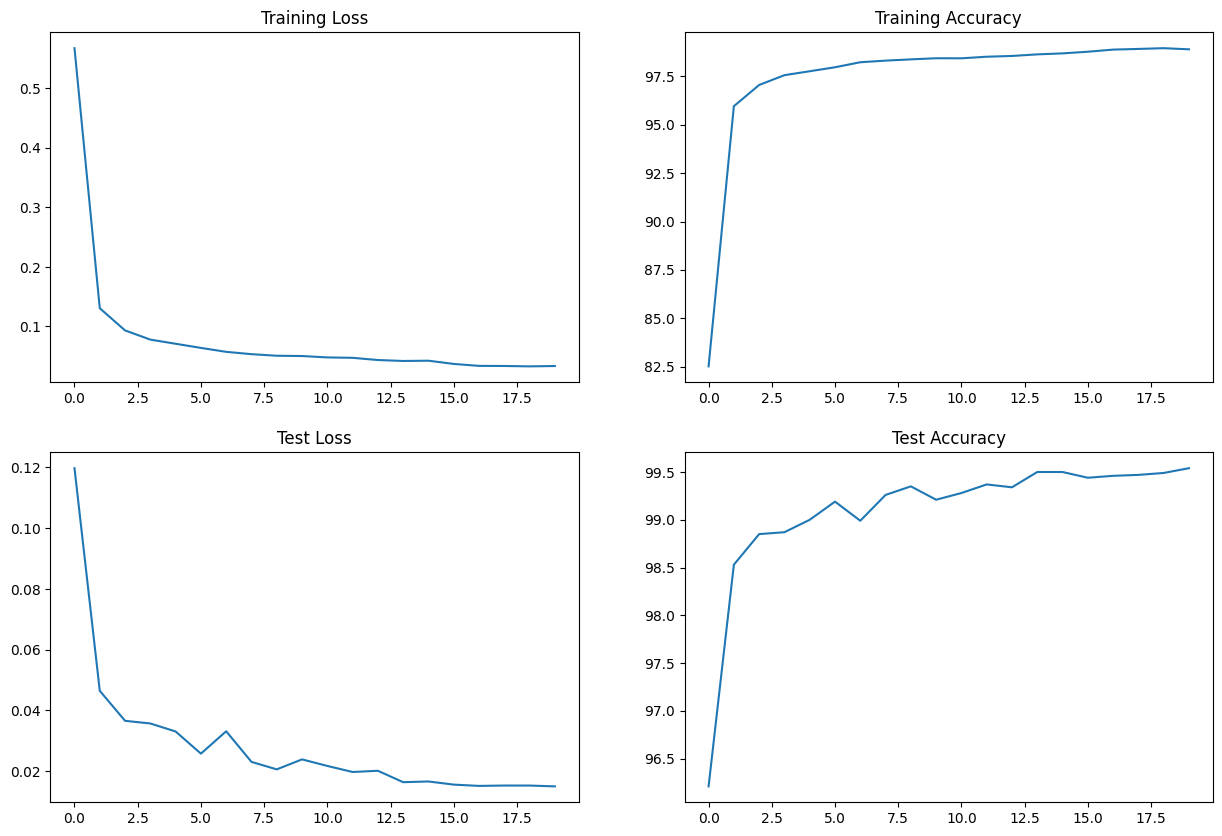

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[0, 1].plot(train_acc)
axs[0, 1].set_title("Training Accuracy")
axs[1, 0].plot(test_losses)
axs[1, 0].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")